In [1]:
import os, h5py
import numpy as np
import pandas as pd
from astropy.io import fits

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import transforms

plt.style.use('default')
sns.set_color_codes()

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Galaxy Predict

In [2]:
def preprocess(data):
    data = Image.fromarray(data.astype(np.uint8))
    data  = transforms.ToTensor()(data)
    data  = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(data)
    return data

with h5py.File('./Data/Galaxy10.h5', 'r') as file:
    data  = file['images'][:]
    label = file['ans'][:]

Val Loss Min
[[ 0.12583682 95.36782662]
 [ 0.45133493 86.61684783]]
Val Acc Max
[[ 0.12061113 95.48611111]
 [ 0.46058712 86.97916667]]


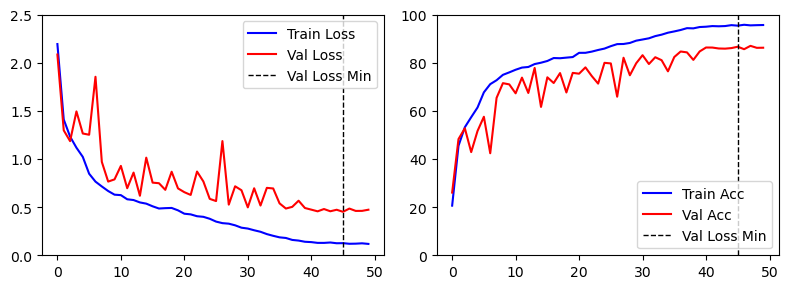

In [3]:
train_logs = np.load('./logs/galaxy/logs.npy')

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(train_logs[:, 0, 0], color='blue', label='Train Loss')
plt.plot(train_logs[:, 1, 0], color='red', label='Val Loss')
plt.vlines(np.argmin(train_logs[:, 1, 0]), 3, 0, ls='--', lw=1, color='black', label='Val Loss Min')
plt.ylim(0, 2.5)
plt.legend()

plt.subplot(122)
plt.plot(train_logs[:, 0, 1], color='blue', label='Train Acc')
plt.plot(train_logs[:, 1, 1], color='red', label='Val Acc')
plt.vlines(np.argmin(train_logs[:, 1, 0]), 0, 100, ls='--', lw=1, color='black', label='Val Loss Min')
plt.ylim(0, 100)
plt.legend()

print('Val Loss Min')
print(train_logs[np.argmin(train_logs[:, 1, 0])])
print('Val Acc Max')
print(train_logs[np.argmax(train_logs[:, 1, 1])])

plt.tight_layout()
plt.show()

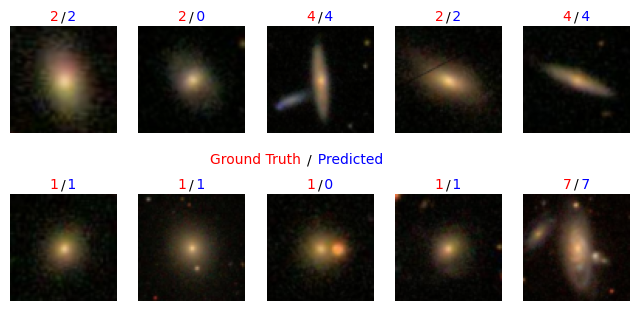

In [4]:
from galaxy_train import GalaxyResNet

model = GalaxyResNet('resnet50', num_classes=10).to(device)
model.load_state_dict(torch.load('./logs/galaxy/best_model.pth'))
model.eval()

plt.figure(figsize=(8, 4))
k = 1
with torch.no_grad():
    for i in range(10):
        img_tensor = preprocess(data[i])
        outputs = model(img_tensor.unsqueeze(0).to(device))
        _, predicted = torch.max(outputs.data, 1)
        plt.subplot(2, 5, k)
        plt.imshow(data[i])
        plt.text(0.5, 1.02, str(int(label[i])) + ' ', ha='right', va='bottom', color='red', transform=plt.gca().transAxes)
        plt.text(0.5, 1.02, '/', ha='center', va='bottom', color='black', transform=plt.gca().transAxes)
        plt.text(0.5, 1.02, ' ' + str(int(predicted)), ha='left', va='bottom', color='blue', transform=plt.gca().transAxes)
        plt.axis('off')
        k += 1

plt.text(-2, 1.25, 'Ground Truth  ', ha='right', va='bottom', color='red', transform=plt.gca().transAxes)
plt.text(-2, 1.25, '/', ha='center', va='bottom', color='black', transform=plt.gca().transAxes)
plt.text(-2, 1.25, '  Predicted', ha='left', va='bottom', color='blue', transform=plt.gca().transAxes)
plt.show()

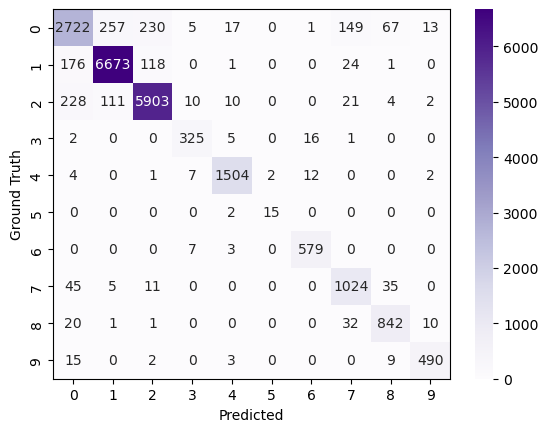

In [5]:
from galaxy_train import GalaxyDataset, GalaxyResNet
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from confusion_matrix import compute_confusion_matrix

model = GalaxyResNet('resnet50', num_classes=10).to(device)
model.load_state_dict(torch.load('./logs/galaxy/best_model.pth'))
model.eval()

dataset       = GalaxyDataset('./Data/Galaxy10.h5')
dataset.val   = True
data_loader   = DataLoader(dataset, batch_size=64)
confusion_mat = compute_confusion_matrix(model, data_loader, device)

ax = sns.heatmap(
    confusion_mat, annot=True, fmt='d', cmap='Purples',
    xticklabels=np.arange(10).astype(np.int64), yticklabels=np.arange(10).astype(np.int64)
)
for _, spine in ax.spines.items(): 
    spine.set_visible(True)

plt.ylabel('Ground Truth')
plt.xlabel('Predicted')
plt.show()

## Spec Predict

Val Loss Min
[[1.30580889e-03 9.99550000e+01]
 [2.46600277e-02 9.95057907e+01]]
Val Acc Max
[[5.19239191e-04 9.99925000e+01]
 [2.84051775e-02 9.95207668e+01]]


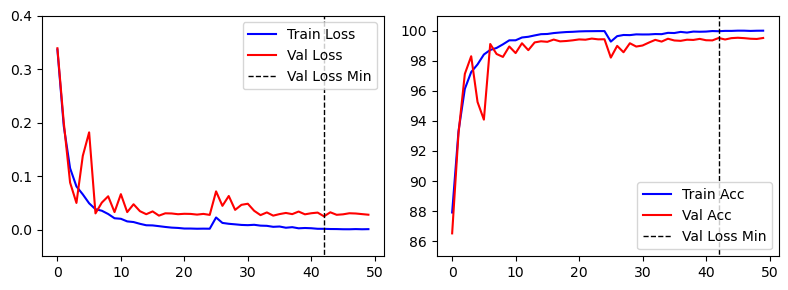

In [6]:
train_logs = np.load('./logs/spec/logs.npy')

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(train_logs[:, 0, 0], color='blue', label='Train Loss')
plt.plot(train_logs[:, 1, 0], color='red', label='Val Loss')
plt.vlines(np.argmin(train_logs[:, 1, 0]), 3, -2, ls='--', lw=1, color='black', label='Val Loss Min')
plt.ylim(-0.05, 0.4)
plt.legend()

plt.subplot(122)
plt.plot(train_logs[:, 0, 1], color='blue', label='Train Acc')
plt.plot(train_logs[:, 1, 1], color='red', label='Val Acc')
plt.vlines(np.argmin(train_logs[:, 1, 0]), 0, 105, ls='--', lw=1, color='black', label='Val Loss Min')
plt.ylim(85, 101)
plt.legend()

print('Val Loss Min')
print(train_logs[np.argmin(train_logs[:, 1, 0])])
print('Val Acc Max')
print(train_logs[np.argmax(train_logs[:, 1, 1])])

plt.tight_layout()
plt.show()

In [7]:
from spec_train import ResNet1D, BasicBlock

model = ResNet1D(BasicBlock, [2, 2, 2, 2], num_classes=3).to(device)
model.load_state_dict(torch.load('./logs/spec/best_model.pth'))
model.eval()

with fits.open('./Data/test_data.fits') as f:
    data  = f[0].data
    objid = f[1].data['objid']

data  = torch.tensor(data.astype(np.float32)).unsqueeze(1)
data  = (data - data.mean(2, keepdim=True)) / data.std(2, keepdim=True)
with torch.no_grad():
    outputs = model(data.to(device))
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()

predicted_csv = pd.DataFrame({'#objid': objid, 'label': predicted})
print(predicted_csv)
predicted_csv.to_csv('Spec_Test.csv', index=None)

     #objid  label
0     20001      2
1     20002      2
2     20003      2
3     20004      2
4     20005      2
..      ...    ...
995   20996      2
996   20997      0
997   20998      2
998   20999      2
999   21000      2

[1000 rows x 2 columns]


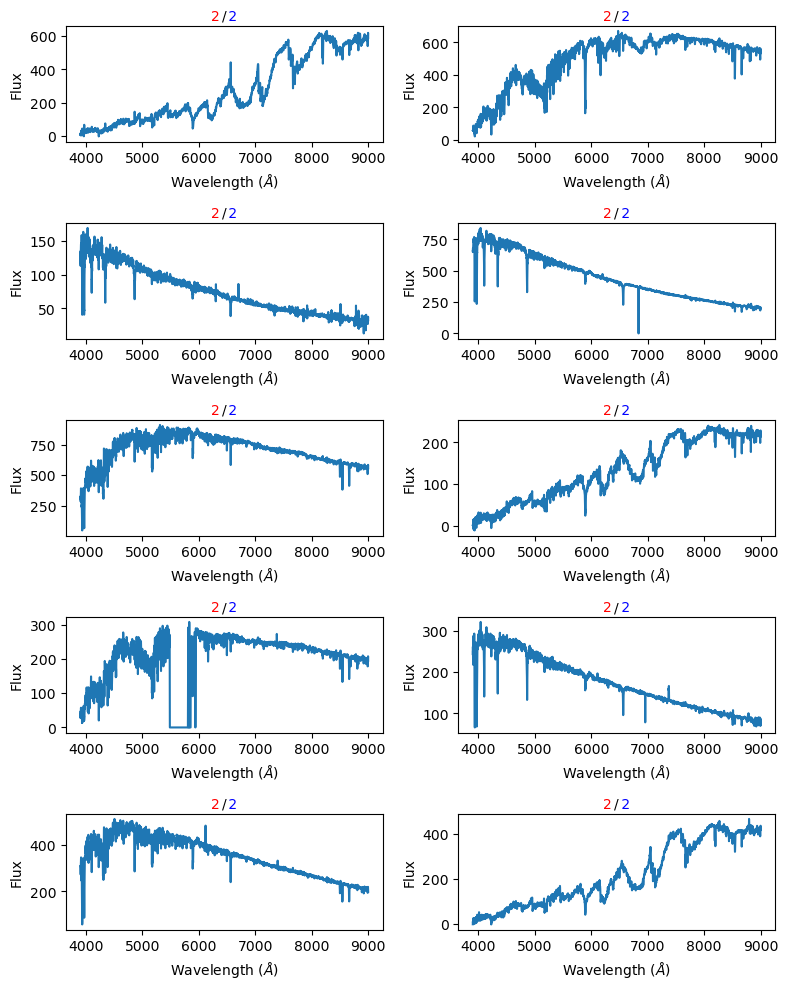

In [8]:
with fits.open('./Data/train_data_10.fits') as f:
    data  = f[0].data
    label = f[1].data['label']
    
wavelength = np.linspace(3900, 9000, 3000)

plt.figure(figsize=(8, 10))
k = 1
with torch.no_grad():
    for i in range(5000, 5010):
        spec  = torch.tensor(data[i].astype(np.float32)).unsqueeze(0).unsqueeze(0)
        spec  = (spec - spec.mean()) / spec.std(2)
        outputs = model(spec.to(device))
        _, predicted = torch.max(outputs.data, 1)
        plt.subplot(5, 2, k)
        plt.plot(wavelength, data[i])
        plt.text(0.5, 1.02, str(int(label[i])) + ' ', ha='right', va='bottom', color='red', transform=plt.gca().transAxes)
        plt.text(0.5, 1.02, '/', ha='center', va='bottom', color='black', transform=plt.gca().transAxes)
        plt.text(0.5, 1.02, ' ' + str(int(predicted)), ha='left', va='bottom', color='blue', transform=plt.gca().transAxes)
        k += 1
        plt.xlabel('Wavelength ({})'.format(f'$\AA$'))
        plt.ylabel('Flux')

plt.tight_layout()
plt.show()

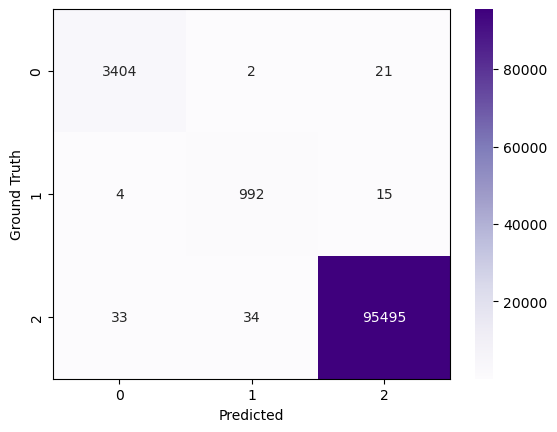

In [9]:
from spec_train import ResNet1D, BasicBlock, SpecDataset
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from confusion_matrix import compute_confusion_matrix

model = ResNet1D(BasicBlock, [2, 2, 2, 2], num_classes=3).to(device)
model.load_state_dict(torch.load('./logs/spec/best_model.pth'))
model.eval()

dataset       = SpecDataset('./Data/train_data_10.fits')
dataset.val   = True
data_loader   = DataLoader(dataset, batch_size=128)
confusion_mat = compute_confusion_matrix(model, data_loader, device)

ax = sns.heatmap(
    confusion_mat, annot=True, fmt='d', cmap='Purples',
    xticklabels=np.arange(3).astype(np.int64), yticklabels=np.arange(3).astype(np.int64)
)
for _, spine in ax.spines.items(): 
    spine.set_visible(True)

plt.ylabel('Ground Truth')
plt.xlabel('Predicted')
plt.show()